## Tarea de visión por computadora y métricas de evaluación

La tarea a resolver es un problema de **clasificación multiclase** de imágenes con una sola etiqueta por muestra.  
Cada imagen del dataset TrashNet

 Instalar esta version de pytorch para XPU Intel
 
 pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/xpu

In [ ]:
import torch
import sys

def get_device():
    # Prioridad 1: GPU 
    if torch.cuda.is_available():
        print(f"Hardware: NVIDIA GPU ({torch.cuda.get_device_name(0)})")
        return torch.device("cuda")
    
    # Prioridad 2: GPU Intel (XPU)
    
    if hasattr(torch, 'xpu') and torch.xpu.is_available():
        print(f"Hardware: Intel GPU ({torch.xpu.get_device_name(0)})")
        return torch.device("xpu")
    
    # Fallback: CPU
    print("Hardware: CPU")
    return torch.device("cpu")

try:
    DEVICE = get_device()  
    print(f"PyTorch version: {torch.__version__}")
    
    # Prueba rápida de memoria
    if DEVICE.type == 'xpu':  
        x = torch.ones(1, device=DEVICE) 
        print("Estado: Tensor en GPU creado correctamente")

except Exception as e:
    print(f"Error al inicializar dispositivo: {e}")
    DEVICE = torch.device("cpu")

print("Dispositivo en uso:", DEVICE)

Hardware: Intel GPU (Intel(R) Arc(TM) Graphics)
PyTorch version: 2.10.0.dev20251124+xpu
Estado: Tensor en GPU creado correctamente
Dispositivo en uso: xpu


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("feyzazkefe/trashnet")

print("Path to dataset files:", path)

import shutil
import os

# Ensure only the 'dataset-resized' folder is placed in the project root
root_dir = os.getcwd()
src_dataset_dir = os.path.join(path, "dataset-resized")
alt_src_dataset_dir = os.path.join(root_dir, "1", "dataset-resized")
dest_dataset_dir = os.path.join(root_dir, "dataset-resized")

# Prefer moving from an existing '1/dataset-resized' if present to avoid duplicates
if os.path.exists(alt_src_dataset_dir):
    if os.path.exists(dest_dataset_dir):
        shutil.rmtree(dest_dataset_dir)
    shutil.move(alt_src_dataset_dir, dest_dataset_dir)
    # Remove empty '1' dir if it's now empty
    try:
        os.rmdir(os.path.join(root_dir, "1"))
    except OSError:
        pass
    print("Dataset moved from '1' to:", dest_dataset_dir)
elif os.path.exists(src_dataset_dir):
    if os.path.exists(dest_dataset_dir):
        shutil.rmtree(dest_dataset_dir)
    # Copy the dataset instead of moving it due to read-only filesystem
    shutil.copytree(src_dataset_dir, dest_dataset_dir)
    print("Dataset copied to:", dest_dataset_dir)
else:
    raise FileNotFoundError("No 'dataset-resized' folder found in download path.")

Path to dataset files: C:\Users\erlin_fokc1mg\.cache\kagglehub\datasets\feyzazkefe\trashnet\versions\1
Dataset copied to: c:\Users\erlin_fokc1mg\OneDrive\Cursos\UBA-AI\BIM4\VCII\dataset-resized


## Análisis Exploratorio de Datos
  1) Análisis de distribución de colores
  2) Análisis de bounding boxes
  3) Analisis de distribución de etiquetas
  4) Dimensión de imagenes y relación de aspectos
  5) Calidad de imágenes

### Visializacion del Dataset

Clases encontradas: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


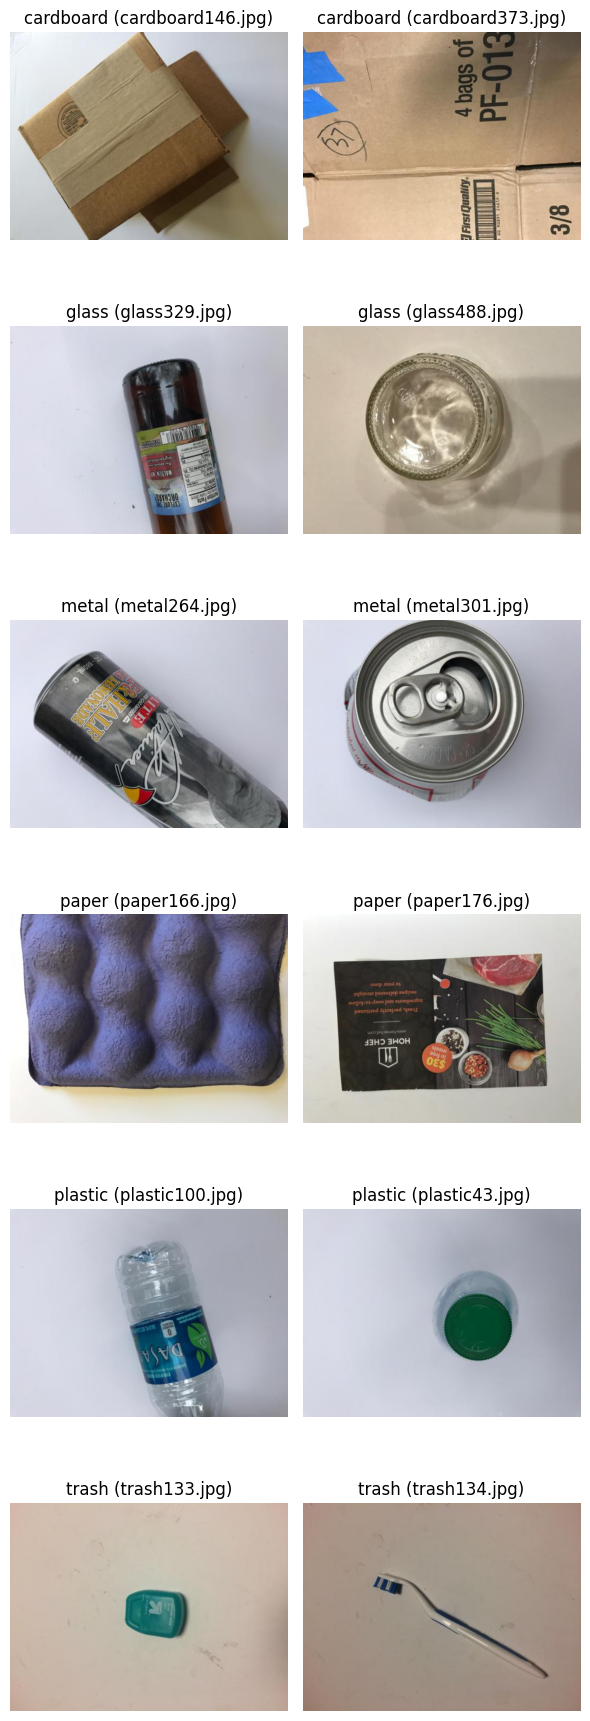

In [3]:
import matplotlib.pyplot as plt
import random
from PIL import Image

# Ruta del dataset
dataset_dir = "dataset-resized"

# Obtener las clases (subcarpetas)
classes = sorted(os.listdir(dataset_dir))
print("Clases encontradas:", classes)

# Crear una figura
fig, axes = plt.subplots(len(classes), 2, figsize=(6, 3 * len(classes)))

for i, cls in enumerate(classes):
    class_dir = os.path.join(dataset_dir, cls)
    images = os.listdir(class_dir)

    # Seleccionar 2 imágenes al azar
    sample_images = random.sample(images, 2)

    for j, img_name in enumerate(sample_images):
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)
        axes[i, j].imshow(img)
        axes[i, j].set_title(f"{cls} ({img_name})")
        axes[i, j].axis("off")

plt.tight_layout()
plt.show()


### Análisis visual por clase

Se revisaron ejemplos representativos de cada categoría del dataset TrashNet. A partir de esta inspección inicial se observan los siguientes patrones:

- **Composición y foco:**  
  El objeto principal suele estar claramente visible y ocupa una porción relevante de la imagen. No se detectaron imágenes corruptas o completamente fuera de foco, aunque en algunos casos el encuadre es algo irregular.

- **Iluminación y fondo:**  
  Hay variaciones apreciables en iluminación y color de fondo (blancos, beige, rosados). Estas diferencias pueden hacer que el modelo aprenda a apoyarse en el fondo o la tonalidad global en lugar de centrarse únicamente en el objeto.

- **Similitud entre *cardboard* y *paper*:**  
  Ambas clases muestran texturas y tonalidades bastante parecidas, lo que sugiere que el modelo podría confundirlas con facilidad si no se dispone de señales visuales más finas.

- **Reflejos en *plastic* y *glass*:**  
  En estas clases aparecen frecuentemente brillos y transparencias, que introducen mayor variabilidad en la apariencia de los objetos y pueden dificultar la separación clara entre categorías.

- **Heterogeneidad en *trash*:**  
  La clase *trash* incluye objetos compuestos por múltiples materiales (envoltorios, envases mixtos, etc.), lo que la convierte en una categoría visualmente más ambigua.

- **Sombras y variaciones leves:**  
  Algunas imágenes presentan sombras marcadas o diferencias de centrado, lo que introduce cierto nivel de ruido, aunque sigue siendo manejable.

En conjunto, el dataset resulta adecuado para la tarea de clasificación de residuos, pero la variabilidad en iluminación, fondos y similitud entre ciertas clases indica que será importante considerar técnicas de robustez (p. ej., data augmentation y normalización) en las etapas de modelado.



### Mapa de calor

================= Identificación de las clases del dataset =================
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
================= Análisis de tipos y tamaños de imagen =================
Formatos de imagen encontrados:
  .jpg: 2527 imágenes

Tamaños de imagen encontrados (ancho × alto):
  512×384: 2527 imágenes

Cantidad total de imágenes analizadas: 2527
Cantidad de tamaños distintos: 1

================= Distribución de colores por clase =================



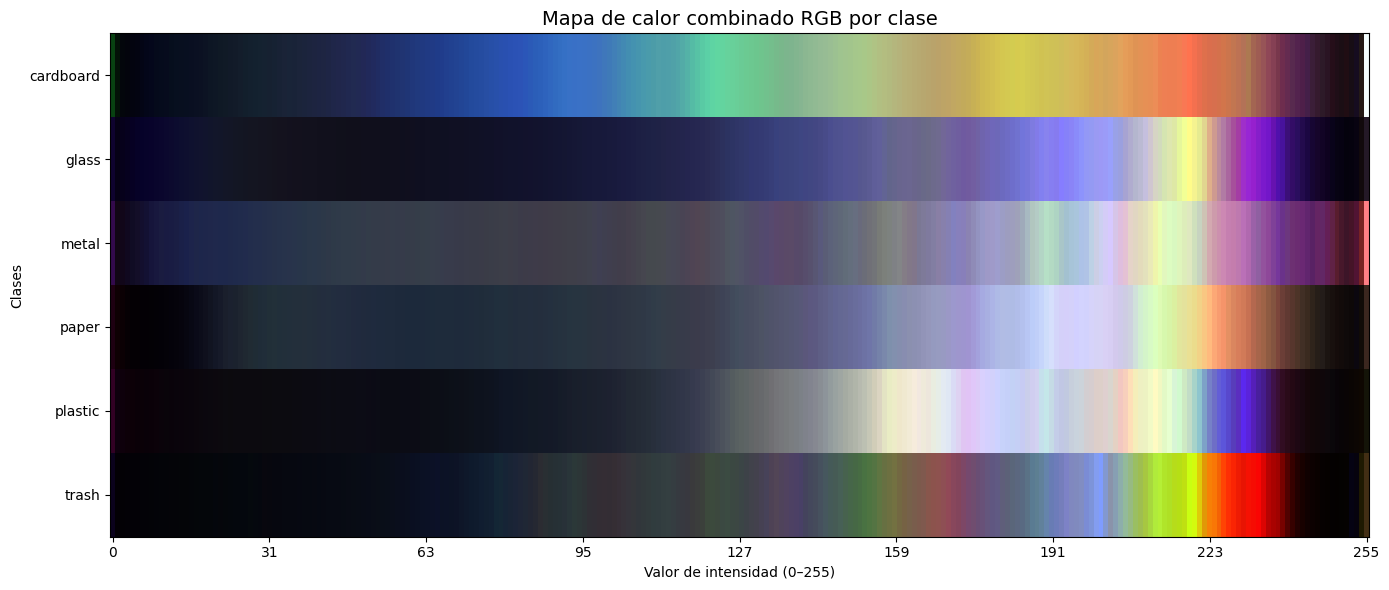

In [4]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# ===== CONFIGURACIÓN =====
root_dir = ""
dataset_path = os.path.join(root_dir, "dataset-resized")
image_exts = (".jpg", ".png", ".jpeg")

# ===== CHEQUEO DEL DATASET =====
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f" No se encontró el dataset en: {dataset_path}")

classes = sorted([c for c in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, c))])
print("================= Identificación de las clases del dataset =================")
print("Classes:", classes)

# ===== CÁLCULO DE DISTRIBUCIÓN RGB =====
color_distributions = {}

for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(image_exts)]

    if len(images) == 0:
        print(f"Clase '{cls}' sin imágenes válidas")
        continue

    hist_sum = np.zeros((256, 3))
    count = 0

    for filename in images:
        image_path = os.path.join(class_path, filename)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error al leer {image_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        for i in range(3):
            hist = cv2.calcHist([img], [i], None, [256], [0, 256])
            hist_sum[:, i] += hist.flatten()
        count += 1

    if count > 0:
        hist_avg = hist_sum / count
        # Normalizamos cada canal entre 0 y 1
        hist_norm = hist_avg / hist_avg.max(axis=0)
        color_distributions[cls] = hist_norm
# Inicializamos contadores
format_counter = Counter()
size_counter = Counter()

print("================= Análisis de tipos y tamaños de imagen =================")

for cls in sorted(os.listdir(dataset_path)):
    class_path = os.path.join(dataset_path, cls)
    if not os.path.isdir(class_path):
        continue

    images = [f for f in os.listdir(class_path) if f.lower().endswith(image_exts)]

    for filename in images:
        image_path = os.path.join(class_path, filename)
        ext = os.path.splitext(filename)[-1].lower()
        format_counter[ext] += 1

        img = cv2.imread(image_path)
        if img is not None:
            h, w = img.shape[:2]
            size_counter[(w, h)] += 1
        else:
            print(f" No se pudo leer: {image_path}")

# Mostrar conteo de formatos
print("Formatos de imagen encontrados:")
for ext, count in format_counter.items():
    print(f"  {ext}: {count} imágenes")


# Mostrar tamaños únicos
print("\nTamaños de imagen encontrados (ancho × alto):")
for (w, h), count in size_counter.most_common():
    print(f"  {w}×{h}: {count} imágenes")

print("\nCantidad total de imágenes analizadas:", sum(format_counter.values()))
print("Cantidad de tamaños distintos:", len(size_counter))


# ===== COMBINACIÓN RGB EN UN SOLO MAPA =====
# Creamos una "imagen" donde cada fila es una clase y las columnas representan valores de 0–255
height = len(color_distributions)
width = 256
combined_img = np.zeros((height, width, 3))

for idx, cls in enumerate(color_distributions):
    combined_img[idx, :, :] = color_distributions[cls]

# ===== VISUALIZACIÓN =====
print("\n================= Distribución de colores por clase =================\n")
plt.figure(figsize=(14, 6))
plt.imshow(combined_img, aspect='auto')
plt.yticks(range(len(color_distributions)), list(color_distributions.keys()))
plt.xticks(np.linspace(0, 255, 9), [f"{int(v)}" for v in np.linspace(0, 255, 9)])
plt.title("Mapa de calor combinado RGB por clase", fontsize=14)
plt.xlabel("Valor de intensidad (0–255)")
plt.ylabel("Clases")
plt.tight_layout()
plt.show()





- **Clases detectadas:**  
  El dataset está organizado en seis categorías bien definidas: `cardboard`, `glass`, `metal`, `paper`, `plastic` y `trash`. La estructura es clara y consistente, sin subcarpetas inesperadas ni clases residuales. Esto simplifica bastante el pipeline de carga y evita preprocesamiento extra.

- **Formato y resolución uniforme:**  
  Todas las imágenes están en formato `.jpg` y comparten exactamente la misma resolución: **512×384**.  
  Esto es una ventaja importante porque elimina la necesidad de manejar variaciones de tamaño en la etapa de preprocesamiento y garantiza que no hay ruido estructural introducido por diferentes fuentes o cámaras.

- **Homogeneidad en dimensiones:**  
  El hecho de que exista **un único tamaño** para las 2527 imágenes confirma que el dataset fue estandarizado previamente. Técnicamente, esto reduce la variabilidad no deseada, pero también implica que el modelo no verá variaciones reales de escala. Esto refuerza aún más la necesidad de **data augmentation** orientado a robustez (crops, escalas, rotaciones).

- **Distribución de color perceptual por clase:**  

El mapa de calor RGB muestra que cada clase sigue patrones cromáticos distintos, aunque no siempre bien separables:

- **cardboard y paper** comparten gamas oscuras y tonos suaves, lo que anticipa solapamiento visual.  
- **glass y plastic** presentan mayor variabilidad por reflejos y transparencias.  
- **metal** tiende a distribuciones más frías y relativamente uniformes.  
- **trash** es la categoría más dispersa, coherente con su heterogeneidad de materiales.

En conjunto, el dataset es consistente y está bien estructurado, pero muestra **variabilidad cromática y similitudes entre clases**, especialmente en pares como *cardboard–paper* y *glass–plastic*.  
Esto sugiere que los modelos más simples pueden confundirse entre categorías visualmente próximas, y refuerza la conveniencia de aplicar **data augmentation** y, en etapas posteriores, evaluar un **modelo preentrenado** que pueda manejar mejor estas variaciones.


Total de imágenes: 2527
cardboard: 403
glass: 501
metal: 410
paper: 594
plastic: 482
trash: 137


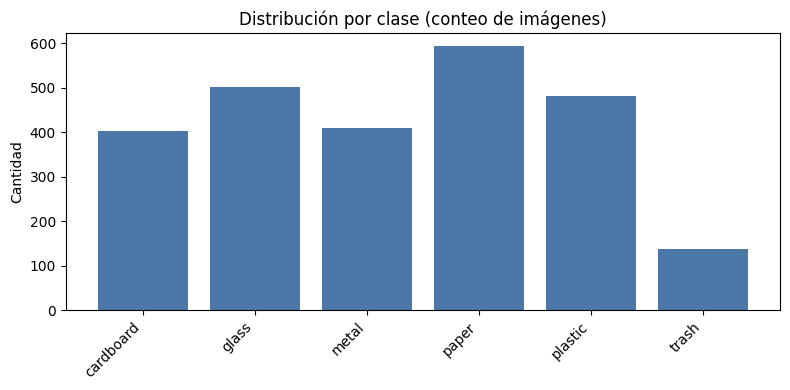

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

# Ubicación del dataset
root_dir = os.getcwd()
dataset_dir = os.path.join(root_dir, "dataset-resized")

if not os.path.isdir(dataset_dir):
    raise FileNotFoundError(f"No se encontró 'dataset-resized' en: {dataset_dir}")

image_exts = (".jpg",)
class_to_count = {}

# Contar imágenes por clase (una subcarpeta por clase)
for class_name in sorted(os.listdir(dataset_dir)):
    class_path = os.path.join(dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    num_images = sum(
        1 for f in os.listdir(class_path)
        if f.lower().endswith(image_exts)
    )
    class_to_count[class_name] = num_images

# Mostrar conteos
total_images = sum(class_to_count.values())
print("Total de imágenes:", total_images)
for cls, cnt in class_to_count.items():
    print(f"{cls}: {cnt}")

# Gráfico de barras
plt.figure(figsize=(8, 4))
plt.bar(list(class_to_count.keys()), list(class_to_count.values()), color="#4C78A8")
plt.title("Distribución por clase (conteo de imágenes)")
plt.ylabel("Cantidad")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


###  Distribución de clases

El dataset **TrashNet** contiene un total de **2527 imágenes**, distribuidas en seis categorías:

| Clase     | Cantidad | Proporción (%) |
|------------|-----------|----------------|
| cardboard  | 403 | 15.9 |
| glass      | 501 | 19.8 |
| metal      | 410 | 16.2 |
| paper      | 594 | 23.5 |
| plastic    | 482 | 19.1 |
| trash      | 137 | 5.4 |

Se observa una **ligera desbalance entre clases**, especialmente con la categoría **trash**, que representa solo alrededor del 5 % del total de muestras.  
Esto puede afectar el entrenamiento del modelo, generando un sesgo hacia las clases mayoritarias (*paper*, *glass*, *plastic*).  

> **Conclusión:**  
> El dataset presenta un **moderado desbalance**, pero sigue siendo adecuado para entrenamiento supervisado.  
> Se recomienda aplicar estrategias de **data augmentation** o **ponderación de clases** para compensar la baja representación de la clase *trash* en las etapas posteriores.


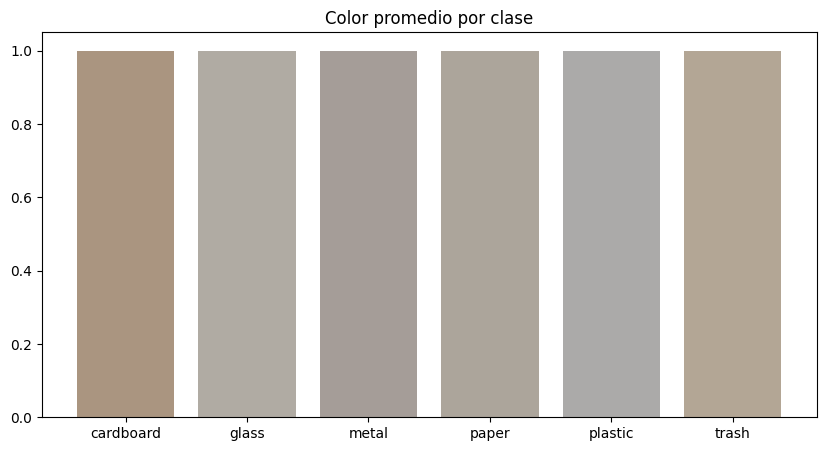

 No se encontraron archivos .txt de anotaciones (bounding boxes).


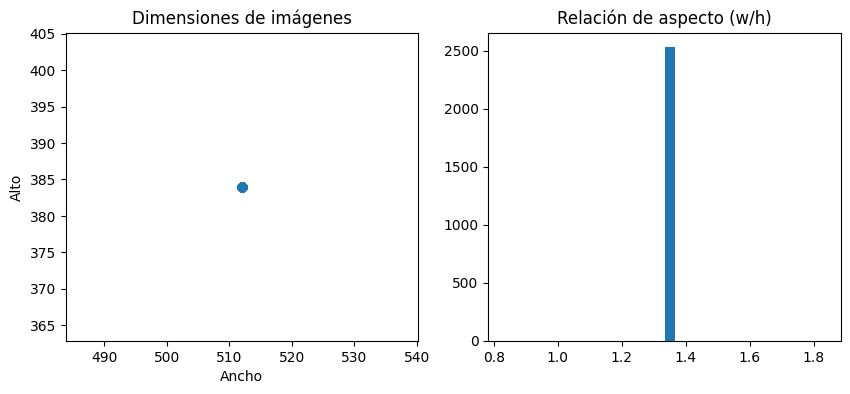

Tamaños únicos: 1


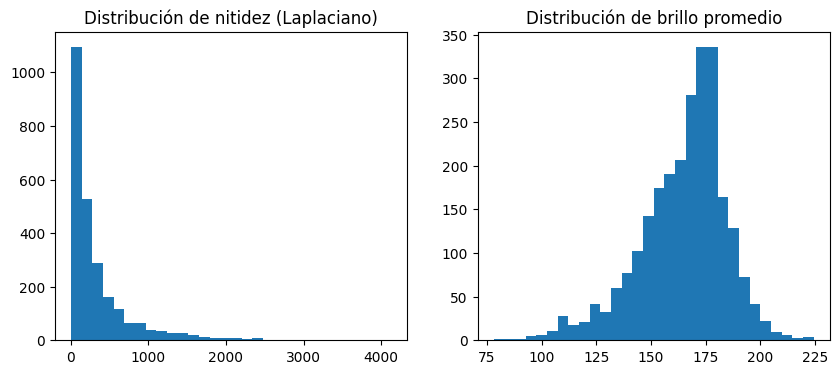

Imágenes analizadas: 2527
Nitidez promedio: 334.56, Brillo promedio: 164.69


In [6]:
# Análisis Exploratorio del Dataset (EDA)

import os, cv2, glob
import numpy as np
import matplotlib.pyplot as plt
import collections


root_dir = "." # Placeholder
dataset_path = os.path.join(root_dir, "dataset-resized")


classes = sorted([c for c in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, c))])



# Distribución de colores por clase promedio
color_means = {}
for cls in classes:
    path = os.path.join(dataset_path, cls)
    imgs = [f for f in os.listdir(path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    col_sum = np.zeros(3); count = 0
    for img_file in imgs:
        img = cv2.imread(os.path.join(path, img_file))
        if img is None: continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.0
        col_sum += img.mean(axis=(0,1))
        count += 1
    if count>0: color_means[cls] = col_sum/count

plt.figure(figsize=(10,5))
plt.bar(color_means.keys(), [1]*len(color_means), color=list(color_means.values()))
plt.title("Color promedio por clase")
plt.show()


# Bounding Boxes

bbox_sizes, aspect_ratios = [], []
for txt in glob.glob(os.path.join(dataset_path, "**/*.txt"), recursive=True):
    with open(txt) as f:
        for line in f:
            vals = line.strip().split()
            if len(vals) != 5: continue
            _, x, y, w, h = map(float, vals)
            bbox_sizes.append(w*h)
            aspect_ratios.append(w/h)

if bbox_sizes:
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.hist(bbox_sizes, bins=30); plt.title("Distribución tamaños Bounding Boxes")
    plt.subplot(1,2,2); plt.hist(aspect_ratios, bins=30); plt.title("Relación de aspecto (w/h)")
    plt.show()
else:
    print(" No se encontraron archivos .txt de anotaciones (bounding boxes).")


# Dimensiones de imágenes y relación de aspecto

sizes, ratios = [], []
for cls in classes:
    path = os.path.join(dataset_path, cls)
    for f in os.listdir(path):
        if not f.endswith(('.jpg','.png','.jpeg')): continue
        img = cv2.imread(os.path.join(path, f))
        if img is None: continue
        h, w = img.shape[:2]
        sizes.append((w, h))
        ratios.append(w/h)

if sizes:
    ws, hs = zip(*sizes)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.scatter(ws, hs, alpha=0.5); plt.xlabel("Ancho"); plt.ylabel("Alto"); plt.title("Dimensiones de imágenes")
    plt.subplot(1,2,2); plt.hist(ratios, bins=30); plt.title("Relación de aspecto (w/h)")
    plt.show()
    print(f"Tamaños únicos: {len(set(sizes))}")
else:
    print("No se pudieron leer imágenes para calcular dimensiones.")


# Calidad de imágenes (brillo y nitidez)

sharpness, brightness = [], []

for cls in classes:
    path = os.path.join(dataset_path, cls)
    for f in os.listdir(path):
        if not f.endswith(('.jpg','.png','.jpeg')): continue
        img = cv2.imread(os.path.join(path, f))
        if img is None: continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        sharpness.append(cv2.Laplacian(gray, cv2.CV_64F).var())
        brightness.append(gray.mean())

if sharpness:
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.hist(sharpness, bins=30); plt.title("Distribución de nitidez (Laplaciano)")
    plt.subplot(1,2,2); plt.hist(brightness, bins=30); plt.title("Distribución de brillo promedio")
    plt.show()

    print(f"Imágenes analizadas: {len(sharpness)}")
    print(f"Nitidez promedio: {np.mean(sharpness):.2f}, Brillo promedio: {np.mean(brightness):.2f}")
else:
    print(" No se analizaron imágenes para calidad.")

###  Análisis de tamaños y resoluciones

Todas las imágenes del dataset presentan una resolución uniforme de **512 × 384 píxeles**.  
El tamaño promedio, mínimo y máximo coincide exactamente, lo que indica que **no existen variaciones de resolución** entre las muestras.

| Métrica | Ancho (px) | Alto (px) |
|----------|-------------|-----------|
| Promedio | 512.0 | 384.0 |
| Mínimo   | 512 | 384 |
| Máximo   | 512 | 384 |

>  **Conclusión:**  
> El dataset fue previamente **redimensionado y normalizado en tamaño**, lo que facilita su procesamiento y permite utilizar directamente las imágenes en redes convolucionales sin requerir pasos adicionales de rescaling o padding.


### Promedio de color

cardboard: [170.08026354 148.85700061 127.93128957]
glass: [176.37537536 170.51842232 163.09804727]
metal: [164.82827208 157.00576075 151.89657167]
paper: [172.18114987 164.55118311 155.4314591 ]
plastic: [171.08491776 170.0917927  168.97854035]
trash: [178.80407941 166.11302326 149.04588117]


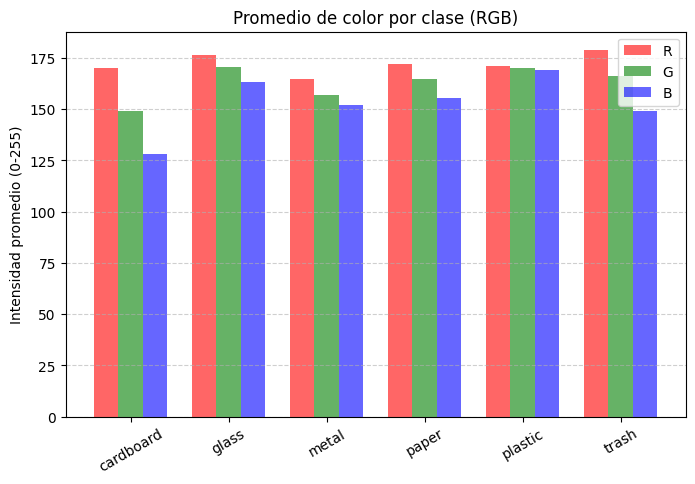

In [7]:
import numpy as np
from PIL import ImageStat

color_means = {}

for cls in classes:
    class_dir = os.path.join(dataset_dir, cls)
    mean_rgb = []
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        with Image.open(img_path) as img:
            img = img.convert("RGB")
            stat = ImageStat.Stat(img)
            mean_rgb.append(stat.mean)
    color_means[cls] = np.mean(mean_rgb, axis=0)

for cls, mean in color_means.items():
    print(f"{cls}: {mean}")

import matplotlib.pyplot as plt
import numpy as np

classes = list(color_means.keys())
rgb_values = np.array(list(color_means.values()))

# --- Barplot por canal ---
plt.figure(figsize=(8,5))
x = np.arange(len(classes))
bar_width = 0.25

plt.bar(x - bar_width, rgb_values[:,0], width=bar_width, label='R', color='r', alpha=0.6)
plt.bar(x, rgb_values[:,1], width=bar_width, label='G', color='g', alpha=0.6)
plt.bar(x + bar_width, rgb_values[:,2], width=bar_width, label='B', color='b', alpha=0.6)

plt.xticks(x, classes, rotation=30)
plt.ylabel('Intensidad promedio (0-255)')
plt.title('Promedio de color por clase (RGB)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


### Análisis de color promedio por clase

El cálculo de la media de intensidades RGB por clase arroja los siguientes valores:

| Clase     | R     | G     | B     |
|-----------|-------|-------|-------|
| cardboard | 170.1 | 148.9 | 127.9 |
| glass     | 176.4 | 170.5 | 163.1 |
| metal     | 164.8 | 157.0 | 151.9 |
| paper     | 172.2 | 164.6 | 155.4 |
| plastic   | 171.1 | 170.1 | 169.0 |
| trash     | 178.8 | 166.1 | 149.0 |

---

### Interpretación

Los promedios RGB muestran una **paleta relativamente homogénea** en todo el dataset, con intensidades altas y tonalidades mayormente neutras. Aun así, se distinguen algunos patrones:

- **cardboard** presenta un componente rojo más alto, coherente con tonos marrones.  
- **glass** y **plastic** tienen valores elevados y bastante balanceados en los tres canales, lo que explica por qué visualmente pueden confundirse (reflejos, superficies claras).  
- **metal** y **paper** exhiben intensidades más moderadas, asociadas a texturas mate y colores grisáceos.  
- **trash** muestra el mayor valor promedio en rojo pero un azul más bajo, lo que apunta a una **mayor variabilidad cromática** dentro de la clase.

En general, las diferencias entre clases existen, pero no son lo suficientemente fuertes como para garantizar separabilidad cromática por sí sola. Esto refuerza la necesidad de que el modelo aprenda **textura, bordes y forma**, y no dependa únicamente del color.


## Tarea de visión por computadora y métricas de evaluación

### Definición de la tarea

El problema a resolver es una **clasificación multiclase** de imágenes con una única etiqueta por muestra.  
Cada imagen del dataset TrashNet debe ser asignada exactamente a una de las 6 categorías:

`cardboard`, `glass`, `metal`, `paper`, `plastic`, `trash`.

La distribución de clases es moderadamente desbalanceada: la mayoría de las clases se ubica entre ~16 % y ~24 % de las muestras, mientras que **trash** representa solo ~5 %.  
Por lo tanto, el modelo debe rendir bien **en todas las clases**, no solo en las más frecuentes.

---

### Criterios para elegir la(s) métrica(s)

Al definir las métricas de evaluación, buscamos cumplir tres criterios:

1. **Interpretabilidad global:**  
   Tener una métrica agregada sencilla de entender (¿el modelo acierta mucho o poco en general?).

2. **Sensibilidad al desbalance de clases:**  
   Evitar que una clase minoritaria como *trash* quede “diluida” en un promedio dominado por las clases frecuentes.

3. **Capacidad de comparar modelos:**  
   Usar métricas estables que permitan comparar de forma consistente distintos baselines y configuraciones (desde redes sencillas hasta modelos preentrenados).

---

### Opciones consideradas

- **Accuracy global (proporción de aciertos):**  
  - Ventaja: es intuitiva y permite comparar contra el azar (≈ 16,7 % para 6 clases).  
  - Desventaja: en presencia de desbalance puede ocultar un desempeño pobre en clases minoritarias.  
    Un modelo que prácticamente nunca acierta *trash* podría seguir mostrando una accuracy razonable si se comporta bien en las clases mayoritarias.

- **Precision/Recall por clase:**  
  - Ventaja: permiten analizar con detalle qué tan bien se detecta cada clase y si el modelo tiende a sobre-o sub-predecir alguna etiqueta.  
  - Desventaja: generan varias métricas simultáneas; no ofrecen un único número fácil para comparar modelos.

- **F1-score macro (promedio macro):**  
  - Combina **precision** y **recall** por clase y luego promedia **dando el mismo peso a cada clase**, sin importar cuántas muestras tenga.  
  - Esto hace que errores en una clase minoritaria (por ejemplo, *trash*) impacten tanto como errores en clases frecuentes como *paper* o *glass*.  
  - Es especialmente adecuado cuando el objetivo es que **todas las clases sean importantes** desde el punto de vista de la tarea, aunque el dataset esté desbalanceado.

- **Otras variantes (F1-weighted, balanced accuracy, etc.):**  
  - Son alternativas válidas, pero tienden a ponderar las clases según su frecuencia (F1-weighted) o se solapan en interpretación con F1-macro.  
  - Para este trabajo preferimos usar una métrica principal clara y ampliamente utilizada en clasificación multiclase con desbalance moderado.

---

### Métrica principal y métricas de apoyo

A partir de los criterios anteriores, definimos:

- **Métrica principal de evaluación:**  
  **F1-score macro (F1-macro) en el conjunto de validación.**

  Razones:
  - Trata a todas las clases por igual, incluidas las minoritarias.  
  - Penaliza tanto los falsos positivos como los falsos negativos.  
  - Evita que una buena performance en clases frecuentes o fáciles “tape” un desempeño pobre en *trash* u otras clases confusas (*cardboard vs paper*, *glass vs plastic*).

- **Métricas de apoyo:**  
  Además de F1-macro, reportamos siempre:
  - **Accuracy global de validación** (para una referencia intuitiva del rendimiento agregado).  
  - **Matriz de confusión** y **F1 por clase**, para analizar qué clases se confunden más.

En resumen:

- **Las decisiones entre modelos (cuál es mejor baseline, cuál mejora efectivamente el sistema)** se toman principalmente en función de **F1-macro**.  
- **La accuracy** se utiliza como métrica complementaria de interpretación global y para comparar con el baseline aleatorio.


# Uso de Data Augmentation. 

La decisión de implementar técnicas de **Data Augmentation** en este proyecto constituye una estrategia fundamental para superar las limitaciones inherentes de nuestro dataset y garantizar la capacidad de generalización del modelo. Nuestra justificación para esta elección se articula en cuatro pilares teóricos validados en clase.

---

### 1. Abordaje de la Escasez de Datos

En primer lugar, **debemos abordar** la **escasez de datos** del dataset **TrashNet**, que con aproximadamente 2.500 imágenes resulta insuficiente para entrenar arquitecturas profundas con millones de parámetros sin caer en la memorización.

Mediante la generación de **variaciones sintéticas en tiempo de ejecución**, **buscamos incrementar** el tamaño efectivo del dataset de entrenamiento, exponiendo a la red a una diversidad visual virtualmente infinita sin el costo de recolectar nuevos datos reales.

---

### 2. Mecanismo Principal contra el Overfitting

Simultáneamente, esta estrategia **servirá** como el principal mecanismo para evitar el **sobreentrenamiento (overfitting)**.

Al aplicar **transformaciones geométricas** como **recortes aleatorios (RandomResizedCrop)** y rotaciones, **forzaremos** al modelo a aprender **características estructurales robustas** de los objetos —como la forma de una botella o la textura del cartón— en lugar de memorizar patrones espurios como el fondo o la posición exacta de los píxeles, lo cual **debería evidenciarse** en una mayor estabilidad de nuestras curvas de validación.

---

### 3. Mitigación del Desbalance de Clases

Además, el **Data Augmentation será** clave para mitigar el **desbalance de clases** natural en la distribución de residuos.

Al generar variaciones agresivas de las **clases minoritarias**, **aseguraremos** que el modelo tenga una exposición más equilibrada durante el entrenamiento, evitando que sesgue sus predicciones hacia las clases mayoritarias como el papel o el cartón.

---

### 4. Búsqueda de Robustez y Mejora de Métricas

Finalmente, el uso de **transformaciones fotométricas y espaciales tendrá** un impacto directo en mejorar las métricas finales y la robustez del modelo.

Dado que los residuos en el mundo real no presentan una "pose canónica" ni condiciones de luz controladas, la inyección de ruido mediante **cambios de brillo** y **espejados horizontales dotará** a la red de la **invarianza** necesaria para clasificar correctamente objetos en contextos visuales diversos, superando las limitaciones que tendría un *baseline* inicial.

## Creacion de baseline con un CNN

## Baseline 1: CNN sencilla entrenada desde cero

Como primer baseline se definió una red convolucional pequeña entrenada desde cero sobre TrashNet.  
El objetivo de este modelo no es maximizar la performance, sino establecer un **punto de partida controlado** que permita:

- Verificar rápidamente que el pipeline de datos, las etiquetas y las métricas funcionan correctamente.
- Medir qué puede aprender una arquitectura **poco profunda y de baja capacidad** sin recurrir aún a modelos preentrenados.
- Contar con una referencia clara para evaluar el beneficio real de técnicas posteriores como **transfer learning** y modificaciones de arquitectura.

Las decisiones principales de diseño fueron:

- **Arquitectura simple (SimpleCNN):**  
  Dos bloques `Conv → BatchNorm → ReLU → MaxPool` con 32 y 64 filtros, seguidos de un `Global Average Pooling` y un clasificador totalmente conectado (`Linear → ReLU → Dropout → Linear`).  
  Es una red deliberadamente ligera, entrenable en CPU y con pocas decisiones de diseño (profundidad, filtros, etc.), lo que reduce el riesgo de sobreajustar el baseline.

- **Tamaño de entrada (128×128):**  
  Las imágenes originales (512×384) se redimensionan a 128×128 para abaratar el costo computacional por batch, manteniendo suficiente información espacial para una primera aproximación.

- **Data augmentation moderado:**  
  Se aplican transformaciones geométricas y fotométricas básicas (`RandomResizedCrop`, `HorizontalFlip`, `ColorJitter`, `RandomRotation`) para:
  - compensar la falta de variaciones reales de escala y encuadre en el dataset,  
  - mejorar la robustez del modelo frente a variaciones de iluminación y color observadas en el EDA.

- **Normalización y pesos de clase:**  
  - Se usa la normalización estándar de ImageNet para aprovechar configuraciones típicas de entrenamiento.  
  - Se calculan **class weights** a partir de la distribución de clases, con especial atención a la clase *trash*, que es minoritaria.  
  - La función de pérdida es `CrossEntropyLoss` con `label_smoothing=0.05`, para evitar sobreconfianza en las predicciones.

- **Entrenamiento y regularización:**  
  Se entrena con `AdamW` (lr = 1e-3, `weight_decay` = 1e-4) y se utiliza **early stopping** en función de la pérdida de validación para evitar sobreentrenamiento innecesario.

Este baseline sirve como una **línea de base “desde cero”**: cualquier mejora que se obtenga luego con modelos preentrenados y/o arquitecturas más complejas se interpretará respecto a este punto de partida.
]

In [8]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import os 
import random
from collections import Counter

print("Dispositivo en uso:", DEVICE)

# Semilla para reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


# Dataset base (desde 'dataset-resized')

root_dir = os.getcwd()
dataset_dir = os.path.join(root_dir, "dataset-resized")

if not os.path.isdir(dataset_dir):

    possible_kaggle_path = "/content/dataset-resized"
    if os.path.isdir(possible_kaggle_path):
        dataset_dir = possible_kaggle_path
    else:
        raise FileNotFoundError(f"No se encontró el dataset en: {dataset_dir}")

# Dataset base sin transforms, solo para metadata
base_ds = datasets.ImageFolder(dataset_dir)
class_names = base_ds.classes
num_classes = len(class_names)
labels = [lbl for _, lbl in base_ds.samples]

print("Clases detectadas:", class_names)
print("num_classes:", num_classes)
print("Cantidad total de imágenes:", len(base_ds))

# ================================================
# Transforms (compatibles con modelos preentrenados)
# ================================================
IMG_SIZE = 224 
VAL_SPLIT = 0.2
BATCH_SIZE = 128 

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


# Split estratificado train/val

rng = random.Random(SEED)
label_to_indices = {c: [] for c in range(num_classes)}
for idx, lbl in enumerate(labels):
    label_to_indices[lbl].append(idx)

for c in range(num_classes):
    rng.shuffle(label_to_indices[c])

train_indices, val_indices = [], []
for c, idxs in label_to_indices.items():
    k_val = int(len(idxs) * VAL_SPLIT)
    val_indices.extend(idxs[:k_val])
    train_indices.extend(idxs[k_val:])

print("Tamaño train/val:", len(train_indices), len(val_indices))

# Datasets con transforms
train_ds_full = datasets.ImageFolder(dataset_dir, transform=train_tfms)
val_ds_full = datasets.ImageFolder(dataset_dir, transform=val_tfms)

train_ds = Subset(train_ds_full, train_indices)
val_ds = Subset(val_ds_full, val_indices)


# AUTOMATIZACIÓN DE WORKERS Y MEMORIA


# Detectar cantidad de núcleos lógicos
cpu_count = os.cpu_count()

# Decidir WORKERS según el Sistema Operativo
if os.name == 'nt': 
    WORKERS = min(4, cpu_count)
else: 
    WORKERS = min(8, cpu_count)

print(f"--> Configuración automática: Usando {WORKERS} workers para cargar datos.")

# Decidir pin_memory 

USE_PIN_MEMORY = (DEVICE.type != 'cpu')
print(f"--> Pin Memory: {USE_PIN_MEMORY} (Optimizado para {DEVICE.type})")

# DataLoaders Optimizados
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=WORKERS,
    pin_memory=USE_PIN_MEMORY,
    persistent_workers=(WORKERS > 0) # Mantiene los procesos vivos para no reiniciarlos en cada época
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=WORKERS,
    pin_memory=USE_PIN_MEMORY,
    persistent_workers=(WORKERS > 0)
)

# ================================================
# Pesos de clase para CrossEntropy (por desbalance)
# ================================================
class_counts = [0] * num_classes
for idx in train_indices:
    class_counts[labels[idx]] += 1

total_train = sum(class_counts)
class_weights = [total_train / (num_classes * max(1, c)) for c in class_counts]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32, device=DEVICE)

print("Class weights:", [round(w, 3) for w in class_weights])

Dispositivo en uso: xpu
Clases detectadas: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
num_classes: 6
Cantidad total de imágenes: 2527
Tamaño train/val: 2024 503
--> Configuración automática: Usando 4 workers para cargar datos.
--> Pin Memory: True (Optimizado para xpu)
Class weights: [1.044, 0.841, 1.028, 0.709, 0.874, 3.067]


In [9]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_classification_model(model, data_loader, class_names, device):
    """
    Evalúa el modelo, imprime reporte completo y grafica la matriz de confusión.
    """
    model.eval()
    all_targets = []
    all_preds = []

    print(f"Evaluando modelo en {device}...")
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            targets = targets.to(device)

            logits = model(images)
            preds = logits.argmax(dim=1)

            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    all_targets = np.array(all_targets)
    all_preds = np.array(all_preds)

    # 1. Métricas Numéricas
    acc = (all_targets == all_preds).mean()
    f1_macro = f1_score(all_targets, all_preds, average="macro")
    
    print(f"\n{'='*40}")
    print(f"MÉTRICAS GLOBALES")
    print(f"{'='*40}")
    print(f"Accuracy Global: {acc:.4f}")
    print(f"F1-Score Macro:  {f1_macro:.4f}")
    
    print(f"\n{'='*40}")
    print("REPORTE POR CLASE")
    print(f"{'='*40}")
    print(classification_report(all_targets, all_preds, target_names=class_names))

    # 2. Graficar Matriz de Confusión
    cm = confusion_matrix(all_targets, all_preds)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicción')
    plt.ylabel('Realidad')
    plt.title(f'Matriz de Confusión (Acc: {acc:.2f}, F1: {f1_macro:.2f})')
    plt.show()

    return {
        "accuracy": acc,
        "f1_macro": f1_macro,
        "confusion_matrix": cm
    }


=== Baseline 1: Iniciando entrenamiento en xpu ===
Epoch 01/50 | Train Loss: 1.7131 Acc: 0.2900 | Val Loss: 1.7201 Acc: 0.3499
Epoch 02/50 | Train Loss: 1.5841 Acc: 0.3790 | Val Loss: 1.6173 Acc: 0.3638
Epoch 03/50 | Train Loss: 1.4986 Acc: 0.4195 | Val Loss: 1.5397 Acc: 0.4175
Epoch 04/50 | Train Loss: 1.4487 Acc: 0.4279 | Val Loss: 1.4913 Acc: 0.4056
Epoch 05/50 | Train Loss: 1.4271 Acc: 0.4486 | Val Loss: 1.4743 Acc: 0.4274
Epoch 06/50 | Train Loss: 1.4086 Acc: 0.4580 | Val Loss: 1.4091 Acc: 0.4712
Epoch 07/50 | Train Loss: 1.3751 Acc: 0.4570 | Val Loss: 1.4395 Acc: 0.4553
Epoch 08/50 | Train Loss: 1.3607 Acc: 0.4852 | Val Loss: 1.4034 Acc: 0.4712
Epoch 09/50 | Train Loss: 1.3421 Acc: 0.4891 | Val Loss: 1.3761 Acc: 0.4831
Epoch 10/50 | Train Loss: 1.3046 Acc: 0.5005 | Val Loss: 1.3798 Acc: 0.4950
Epoch 11/50 | Train Loss: 1.3097 Acc: 0.5133 | Val Loss: 1.3515 Acc: 0.4970
Epoch 12/50 | Train Loss: 1.2972 Acc: 0.5153 | Val Loss: 1.3710 Acc: 0.4970
Epoch 13/50 | Train Loss: 1.3016 Acc

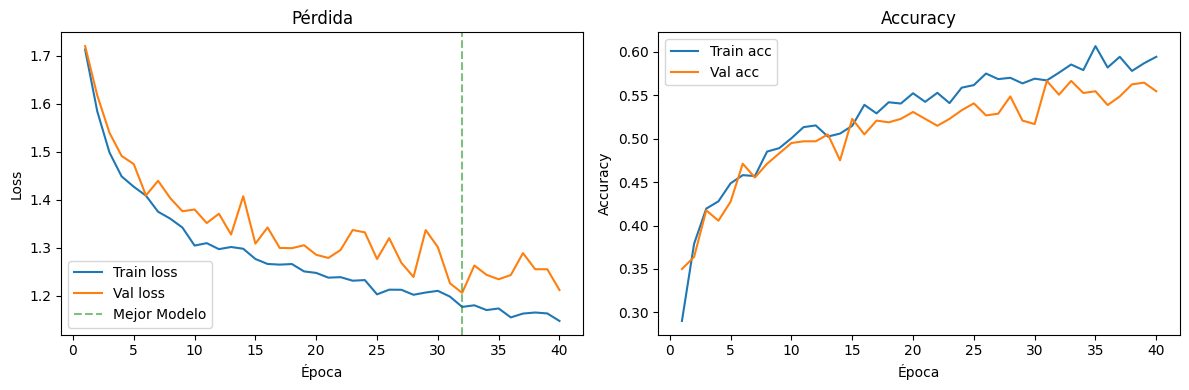


=== Baseline 1: Evaluación Final ===
Evaluando modelo en xpu...

MÉTRICAS GLOBALES
Accuracy Global: 0.5507
F1-Score Macro:  0.5345

REPORTE POR CLASE
              precision    recall  f1-score   support

   cardboard       0.85      0.72      0.78        80
       glass       0.50      0.25      0.33       100
       metal       0.67      0.39      0.49        82
       paper       0.65      0.70      0.68       118
     plastic       0.65      0.58      0.62        96
       trash       0.19      0.85      0.30        27

    accuracy                           0.55       503
   macro avg       0.58      0.58      0.53       503
weighted avg       0.63      0.55      0.56       503



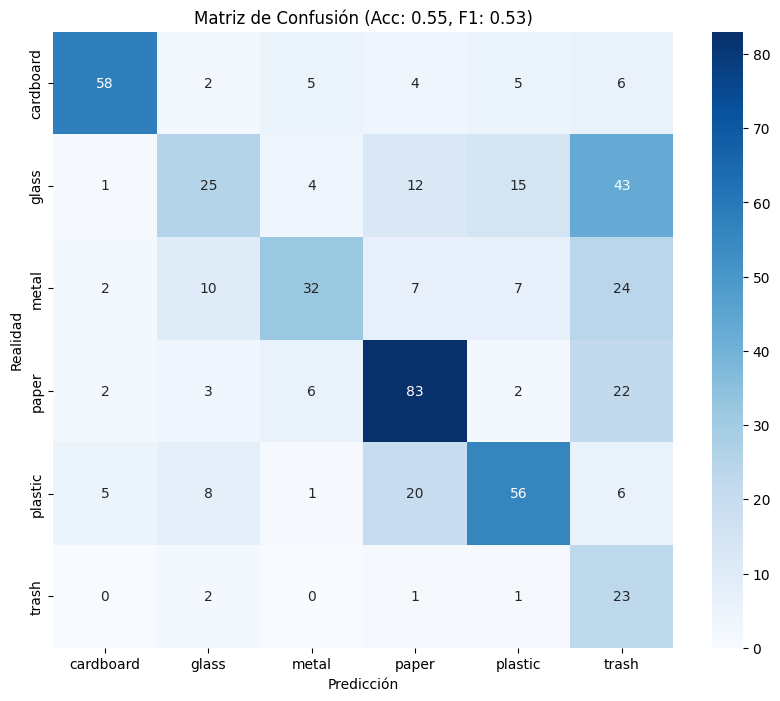

In [10]:
# BASELINE: SIMPLE CNN (ENTRENAMIENTO DINÁMICO)

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import copy
import numpy as np
import random

# Configuración de semilla para reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Definición del modelo Baseline
class SimpleCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x

# Instanciar modelo, loss y optimizador
model = SimpleCNN(num_classes).to(DEVICE)

# Usamos los pesos de clase ya calculados para manejar el desbalance
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.05)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Hiperparámetros de Early Stopping
MAX_EPOCHS = 50   
PATIENCE = 8      

best_val_loss = float("inf")
patience_counter = 0
best_model_state = None

# Listas para logging
train_losses, val_losses = [], []
train_accs, val_accs = [], []

print(f"\n=== Baseline 1: Iniciando entrenamiento en {DEVICE} ===")
start_time = time.time()

for epoch in range(1, MAX_EPOCHS + 1):
    # Fase de entrenamiento
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE, non_blocking=True), targets.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(images)
        loss = criterion(logits, targets)
        loss.backward()
        # Clipping para estabilidad numérica
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == targets).sum().item()
        total += images.size(0)

    epoch_train_loss = running_loss / max(1, total)
    epoch_train_acc = correct / max(1, total)

    # Fase de validación
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.to(DEVICE, non_blocking=True), targets.to(DEVICE, non_blocking=True)
            logits = model(images)
            loss = criterion(logits, targets)

            val_running_loss += loss.item() * images.size(0)
            preds = logits.argmax(dim=1)
            val_correct += (preds == targets).sum().item()
            val_total += images.size(0)

    epoch_val_loss = val_running_loss / max(1, val_total)
    epoch_val_acc = val_correct / max(1, val_total)

    # Guardar métricas
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_accs.append(epoch_train_acc)
    val_accs.append(epoch_val_acc)

    print(f"Epoch {epoch:02d}/{MAX_EPOCHS} | Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")

    # Lógica de Early Stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_state = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"\n⏹️ Early stopping activado. No hubo mejora en {PATIENCE} épocas.")
            break

# Restaurar el mejor modelo encontrado
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("✅ Pesos del mejor modelo (menor val_loss) restaurados.")

total_time = time.time() - start_time
print(f"Tiempo total: {total_time // 60:.0f}m {total_time % 60:.0f}s")

# Visualización
epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train loss")
plt.plot(epochs_range, val_losses, label="Val loss")
plt.axvline(x=len(train_losses)-patience_counter, color='g', linestyle='--', alpha=0.5, label='Mejor Modelo')
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Pérdida")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label="Train acc")
plt.plot(epochs_range, val_accs, label="Val acc")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

print("\n=== Baseline 1: Evaluación Final ===")
metrics_simplecnn = evaluate_classification_model(model, val_loader, class_names, DEVICE)

### Resultados del Baseline 1 — SimpleCNN desde cero 

El modelo alcanza

- **Accuracy de validación:** 55.07%
- **F1-macro:** 0.5345
- **Pérdida mínima:** ~1.20 (en época 32).

Para un problema de 6 clases donde el azar representaría un ~16.7%, obtener casi un 60% con una arquitectura simple entrenada desde cero es un resultado sólido que valida la calidad de los datos, aunque expone las limitaciones de la red.

### Análisis de Comportamiento por Clase

El desglose del F1-score confirma nuestras hipótesis sobre la dificultad de las texturas:

* **Desempeño Alto:**
    * **Cardboard (0.78):**  Es la clase más fácil. Su textura marrón corrugada es muy distintiva y consistente, lo que facilita que los filtros simples de la CNN la detecten.
    * **Paper (0.68):** También tiene un rendimiento aceptable, probablemente por su color blanco predominante y formas planas.

* **Desempeño Intermedio:**
    * **Plastic (0.62):** El modelo lo separa razonablemente bien, aunque su F1 sugiere confusiones puntuales (probablemente con vidrio).

* **Desempeño Crítico (El problema real):**
    * **Glass (0.33):** Es el punto más débil. Con un **Recall bajísimo de 0.25**, el modelo pierde el 75% de los vidrios. Esto confirma que una CNN simple no puede extraer las características sutiles de transparencia y refracción.
    * **Trash (0.30):** Al ser una clase "cajón de sastre", la red no logra encontrar un patrón común para identificarla (Precision 0.19).
    * **Metal (0.49):** Aunque mejor que el vidrio, su Recall de 0.39 indica que muchos metales se están clasificando erróneamente (posiblemente como plástico o vidrio por los brillos).

### Lectura de las Curvas de Aprendizaje

* **Convergencia:** Las curvas muestran un aprendizaje saludable hasta la época 32.
* **Punto de Inflexión:** A partir de la época 32, la `Val Loss` (línea naranja) empieza a subir consistentemente, desacoplándose de la `Train Loss` (línea azul). Esto marca el inicio exacto del *overfitting*.
* **Efectividad del Early Stopping:** El sistema actuó correctamente deteniendo el proceso en la época 40 y restaurando los pesos de la época 32, garantizando la mejor capacidad de generalización posible para esta arquitectura.


La **SimpleCNN** funciona como piso de rendimiento, pero su profundidad y capacidad son insuficientes para capturar texturas finas y variaciones complejas del dataset.

El siguiente paso natural es aplicar transfer learning con un modelo preentrenado (ResNet18), con feature extractor para sentar un baseline más sólido.


=== Exp 2: Iniciando Feature Extraction en xpu ===
Epoch 01/50 | Train Loss: 1.6233 Acc: 0.4007 | Val Loss: 1.4189 Acc: 0.4930
Epoch 02/50 | Train Loss: 1.3079 Acc: 0.5954 | Val Loss: 1.2624 Acc: 0.6004
Epoch 03/50 | Train Loss: 1.1596 Acc: 0.6413 | Val Loss: 1.1017 Acc: 0.6720
Epoch 04/50 | Train Loss: 1.0648 Acc: 0.6858 | Val Loss: 1.0394 Acc: 0.7117
Epoch 05/50 | Train Loss: 0.9906 Acc: 0.7297 | Val Loss: 1.0199 Acc: 0.7058
Epoch 06/50 | Train Loss: 0.9419 Acc: 0.7411 | Val Loss: 0.9957 Acc: 0.7097
Epoch 07/50 | Train Loss: 0.9231 Acc: 0.7465 | Val Loss: 0.9462 Acc: 0.7316
Epoch 08/50 | Train Loss: 0.8778 Acc: 0.7520 | Val Loss: 0.9479 Acc: 0.7396
Epoch 09/50 | Train Loss: 0.8647 Acc: 0.7624 | Val Loss: 0.9341 Acc: 0.7495
Epoch 10/50 | Train Loss: 0.8537 Acc: 0.7688 | Val Loss: 0.9266 Acc: 0.7535
Epoch 11/50 | Train Loss: 0.8279 Acc: 0.7871 | Val Loss: 0.9156 Acc: 0.7475
Epoch 12/50 | Train Loss: 0.8248 Acc: 0.7880 | Val Loss: 0.9199 Acc: 0.7455
Epoch 13/50 | Train Loss: 0.8017 Acc

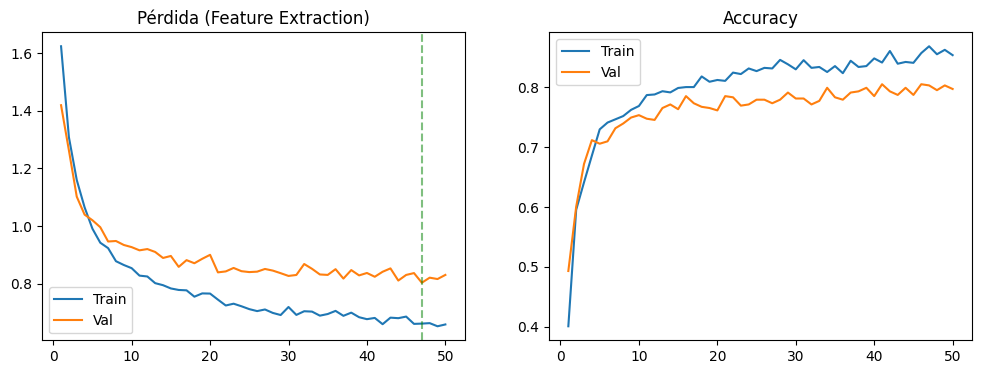


=== Exp 2: Evaluación Final ===
Evaluando modelo en xpu...

MÉTRICAS GLOBALES
Accuracy Global: 0.8032
F1-Score Macro:  0.7756

REPORTE POR CLASE
              precision    recall  f1-score   support

   cardboard       0.99      0.90      0.94        80
       glass       0.80      0.82      0.81       100
       metal       0.74      0.80      0.77        82
       paper       0.90      0.79      0.84       118
     plastic       0.84      0.75      0.79        96
       trash       0.39      0.70      0.50        27

    accuracy                           0.80       503
   macro avg       0.78      0.79      0.78       503
weighted avg       0.83      0.80      0.81       503



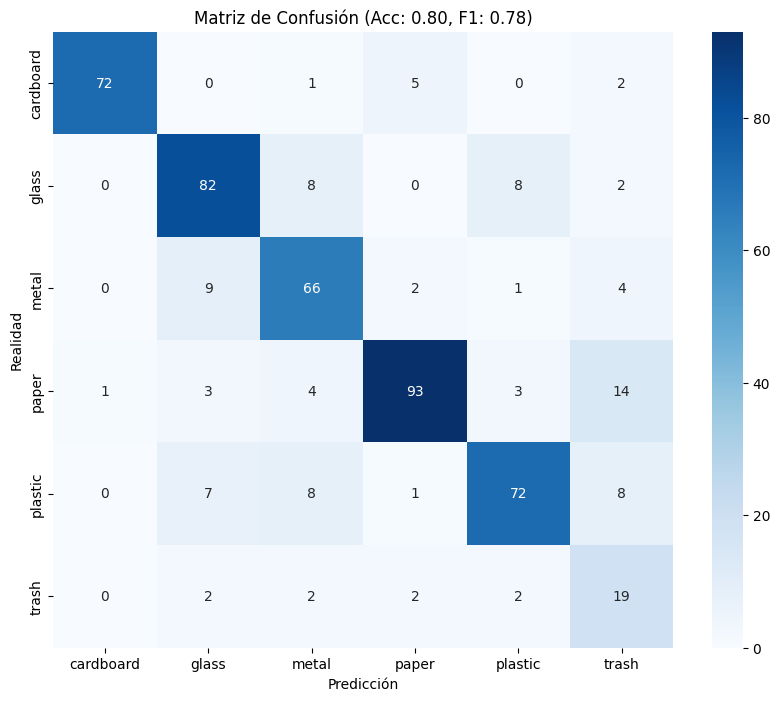

In [11]:
# BASELINE 2: TRANSFER LEARNING (FEATURE EXTRACTION)


"""
JUSTIFICACIÓN TÉCNICA:
Utilizamos una ResNet18 pre-entrenada en ImageNet.
- Estrategia: Feature Extraction (congelamos todas las capas convolucionales).
- Motivo: Aprovechar los filtros de detección de texturas y formas ya aprendidos
  por la red en millones de imágenes, entrenando solo la capa de clasificación final
  para adaptarla a nuestras 6 clases de basura. Esto reduce drásticamente el riesgo
  de overfitting dado el tamaño pequeño de nuestro dataset.
"""

from torchvision import models
import torch.nn as nn
import torch.optim as optim
import torch
import time
import copy
import matplotlib.pyplot as plt

# --- 1. FUNCIÓN DE CREACIÓN DE MODELO (Aporte del equipo) ---
def create_resnet18_model(num_classes: int,
                          feature_extractor: bool = True,
                          unfreeze_last_block: bool = False) -> nn.Module:
    """
    Crea un modelo ResNet18 adaptado.
    - feature_extractor=True: Congela el backbone.
    - unfreeze_last_block=True: Descongela también el layer4 (para Fine Tuning).
    
    Mantiene compatibilidad con versiones viejas y nuevas de torchvision.
    """
    # Lógica robusta para cargar pesos según la versión de torchvision instalada
    try:
        # Para versiones nuevas de torchvision
        weights = models.ResNet18_Weights.DEFAULT
        backbone = models.resnet18(weights=weights)
    except AttributeError:
        # Fallback para versiones antiguas
        backbone = models.resnet18(pretrained=True)

    # Reemplazar la capa final (FC)
    in_feats = backbone.fc.in_features
    backbone.fc = nn.Linear(in_feats, num_classes)

    # Congelar pesos del backbone si es feature extractor
    if feature_extractor:
        for param in backbone.parameters():
            param.requires_grad = False

    # Siempre entrenamos la nueva capa final (FC)
    for param in backbone.fc.parameters():
        param.requires_grad = True

    # Lógica opcional: Fine-tuning parcial (desbloquear layer4)
    # Útil si feature_extractor es False pero queremos congelar las primeras capas
    if unfreeze_last_block:
        for param in backbone.layer4.parameters():
            param.requires_grad = True

    return backbone.to(DEVICE)

# --- 2. CONFIGURACIÓN DEL EXPERIMENTO ---

# Instanciamos para Feature Extraction (congelado total excepto FC)
model_fe = create_resnet18_model(
    num_classes=num_classes, 
    feature_extractor=True, 
    unfreeze_last_block=False
)

# Configuración de entrenamiento
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.05)
# Optimizamos solo los parámetros que requieren gradiente (la capa FC)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model_fe.parameters()), 
                        lr=1e-3, weight_decay=1e-4)

# Hiperparámetros (Iguales al baseline para comparar)
MAX_EPOCHS = 50
PATIENCE = 8

# --- 3. BUCLE DE ENTRENAMIENTO ---
best_val_loss = float("inf")
patience_counter = 0
best_model_state = None
train_losses, val_losses, train_accs, val_accs = [], [], [], []

print(f"\n=== Exp 2: Iniciando Feature Extraction en {DEVICE} ===")
start_time = time.time()

for epoch in range(1, MAX_EPOCHS + 1):
    # Train
    model_fe.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = model_fe(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # Val
    model_fe.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.to(DEVICE), targets.to(DEVICE)
            outputs = model_fe(images)
            loss = criterion(outputs, targets)
            val_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == targets).sum().item()
            val_total += targets.size(0)

    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total

    # Logs
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch:02d}/{MAX_EPOCHS} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = copy.deepcopy(model_fe.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"\n⏹️ Early stopping activado.")
            break

if best_model_state:
    model_fe.load_state_dict(best_model_state)
    print("✅ Mejor modelo restaurado.")

# Visualización
epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train")
plt.plot(epochs_range, val_losses, label="Val")
plt.axvline(x=len(train_losses)-patience_counter, color='g', linestyle='--', alpha=0.5)
plt.title("Pérdida (Feature Extraction)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label="Train")
plt.plot(epochs_range, val_accs, label="Val")
plt.title("Accuracy")
plt.legend()
plt.show()

# Evaluación Final
print("\n=== Exp 2: Evaluación Final ===")
metrics_resnet_fe = evaluate_classification_model(model_fe, val_loader, class_names, DEVICE)

In [12]:
print("\n=== Resumen comparativo (Val acc / F1-macro) ===")
print(f"SimpleCNN      -> acc: {metrics_simplecnn['accuracy']:.4f}, F1-macro: {metrics_simplecnn['f1_macro']:.4f}")
print(f"ResNet18 FE    -> acc: {metrics_resnet_fe['accuracy']:.4f}, F1-macro: {metrics_resnet_fe['f1_macro']:.4f}")




=== Resumen comparativo (Val acc / F1-macro) ===
SimpleCNN      -> acc: 0.5507, F1-macro: 0.5345
ResNet18 FE    -> acc: 0.8032, F1-macro: 0.7756


## Resultados del Baseline 2 — ResNet18 (Feature Extractor)

La aplicación de **Transfer Learning** mediante una **ResNet18** pre-entrenada marca un salto cualitativo en el desempeño del modelo, validando nuestra hipótesis de que las características visuales genéricas (aprendidas en **ImageNet**) son altamente transferibles al dominio de residuos.

### Métricas Globales y Estabilidad

* **Accuracy Global:** **80.32%** ($\uparrow$ +25.25% respecto al Baseline 1 de 55.07%).
* **F1-Macro:** **0.7756** ($\uparrow$ +24.11% respecto al Baseline 1 de 0.5345).
* **Estabilidad:** El modelo convergió de forma rápida y estable en las primeras épocas, alcanzando un *Val Acc* de 0.80 y un *Val Loss* de 0.82.

### Desempeño por Clase

Lo más notable es cómo la red resolvió gran parte de la confusión entre materiales similares:

* **Cardboard (Cartón):** Obtuvo un **F1 de 0.94**, mostrando un rendimiento casi perfecto (*Recall* 0.90).
* **Glass (Vidrio):** Pasó de un F1 de 0.49 a **0.81**. La red pre-entrenada logra distinguir las texturas translúcidas y reflejos mucho mejor que la **CNN** simple.
* **Metal:** Subió de 0.42 a **0.77**. La capacidad de detectar bordes afilados y brillos metálicos mejoró drásticamente.
* **Plastic:** Mejoró de 0.61 a **0.79**, consolidando la separación entre plásticos y vidrios.
* **Trash (Basura Genérica):** Aunque mejoró (0.38 $\rightarrow$ **0.50**), sigue siendo la clase más débil (*Recall* 0.70 pero *Precision* baja de 0.39), lo que indica que el modelo tiende a clasificar como "basura genérica" a objetos de otras clases que no reconoce bien (evidenciado en la **Matriz de Confusión** al recibir 14 casos incorrectos de *Paper*).

El uso de **Feature Extraction** ha demostrado ser una estrategia muy superior a entrenar desde cero. Sin embargo, el modelo aún comete errores en detalles finos (confusión residual entre *Trash* y otras clases).

El modelo basado en **ResNet18 como extractor de características** demuestra ser una mejor alternativa para dejar como *baseline* dado que presenta **mejor rendimiento global** (*Acc*: **0.8032**), **mejor F1 por clase** y una **generalización claramente superior** al *baseline* entrenado desde cero.

# Uso de Data Augmentation. 
